# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

## inits

In [1]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\stim_dataset_2.h5'
model_name = r'D:\github\fish-tracking\train\models\stim_model.h5'
validation_split = .1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

data_generator = DataGenerator(dataset, zeros_to_nan=True)

%load_ext autoreload
%autoreload 2

## view sample frame

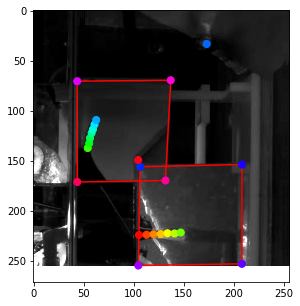

-1


In [3]:
frame_num = np.random.choice(len(data_generator))

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)

## set up image augmentation

In [7]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

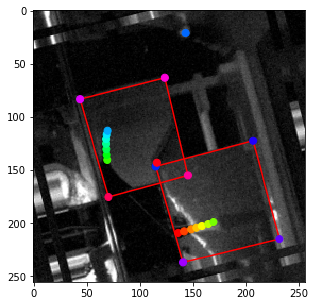

In [10]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [11]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=validation_split, 
                                    use_graph=True,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 82,
 'n_validation': 9,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 52,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset_2.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 91,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (24, 2)}

# check `TrainingGenerator` output

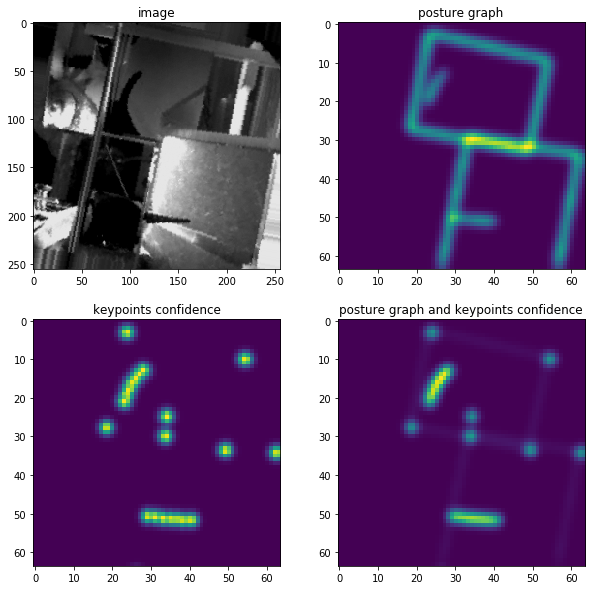

In [12]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# define a model

In [13]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 82,
 'n_validation': 9,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 52,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset_2.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 91,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (24, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [10]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=100)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 32s 3ms/sample
313.95991022535156


# define training callbacks

In [14]:
logger = Logger(validation_batch_size=4,
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/800
4/5 [=======================>......] - ETA: 2s - loss: 325.1241 - output_0_loss: 109.6496 - output_1_loss: 108.4664 - output_2_loss: 107.0081evaluation_metrics: 
euclidean - mean: 4515.68 (0%:  1.01, 5%:  2.83, 25%: 21.29, 50%: 98.03, 75%: 153.79, 95%: 230.06, 100%: 141656.56) 
confidence - mean:  0.01 (0%: -0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.01, 95%:  0.02, 100%:  0.02) 


Epoch 00001: val_loss improved from inf to 323.73624, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 18s 4s/step - loss: 322.6512 - output_0_loss: 109.2163 - output_1_loss: 107.5632 - output_2_loss: 105.8718 - val_loss: 323.7362 - val_output_0_loss: 111.3270 - val_output_1_loss: 107.4149 - val_output_2_loss: 104.9944
Epoch 2/800
4/5 [=======================>......] - ETA: 0s - loss: 306.1427 - output_0_loss: 106.3803 - output_1_loss: 100.9922 - output_2_loss: 98.7701evaluation_metrics: 
euclidean - mean: 4491.09 (0%:  0.16, 5%:  2.8

Epoch 24/800
4/5 [=======================>......] - ETA: 1s - loss: 101.1068 - output_0_loss: 41.9306 - output_1_loss: 32.4160 - output_2_loss: 26.7602evaluation_metrics: 
euclidean - mean: 4496.54 (0%:  0.24, 5%:  1.73, 25%:  5.23, 50%: 74.64, 75%: 122.01, 95%: 227.99, 100%: 141658.50) 
confidence - mean:  0.08 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.06, 75%:  0.12, 95%:  0.24, 100%:  0.32) 


Epoch 00024: val_loss did not improve from 202.51751
5/5 [==============================] - 8s 2s/step - loss: 101.2010 - output_0_loss: 42.0740 - output_1_loss: 32.3835 - output_2_loss: 26.7434 - val_loss: 261.7443 - val_output_0_loss: 98.1962 - val_output_1_loss: 83.2810 - val_output_2_loss: 80.2671
Epoch 25/800
4/5 [=======================>......] - ETA: 1s - loss: 95.2078 - output_0_loss: 40.9517 - output_1_loss: 30.3445 - output_2_loss: 23.9116evaluation_metrics: 
euclidean - mean: 4498.99 (0%:  0.35, 5%:  1.23, 25%:  5.38, 50%: 86.63, 75%: 127.05, 95%: 227.29, 100%: 141661.15) 
confiden

Epoch 36/800
4/5 [=======================>......] - ETA: 1s - loss: 82.2854 - output_0_loss: 37.8183 - output_1_loss: 26.3185 - output_2_loss: 18.1485evaluation_metrics: 
euclidean - mean: 5205.33 (0%:  0.52, 5%:  1.14, 25%:  2.47, 50%:  6.15, 75%: 102.45, 95%: 229.88, 100%: 141572.46) 
confidence - mean:  0.16 (0%:  0.01, 5%:  0.03, 25%:  0.07, 50%:  0.13, 75%:  0.24, 95%:  0.37, 100%:  0.52) 


Epoch 00036: val_loss did not improve from 202.51751
5/5 [==============================] - 8s 2s/step - loss: 81.0462 - output_0_loss: 37.5249 - output_1_loss: 25.9072 - output_2_loss: 17.6140 - val_loss: 213.5983 - val_output_0_loss: 86.1039 - val_output_1_loss: 66.1926 - val_output_2_loss: 61.3017
Epoch 37/800
4/5 [=======================>......] - ETA: 1s - loss: 78.8392 - output_0_loss: 36.9270 - output_1_loss: 25.1242 - output_2_loss: 16.7881evaluation_metrics: 
euclidean - mean: 4467.06 (0%:  0.15, 5%:  0.98, 25%:  2.04, 50%:  4.66, 75%: 95.94, 95%: 228.02, 100%: 141572.54) 
confidence 

Epoch 47/800
4/5 [=======================>......] - ETA: 1s - loss: 74.8301 - output_0_loss: 35.8363 - output_1_loss: 23.6995 - output_2_loss: 15.2943evaluation_metrics: 
euclidean - mean: 5181.44 (0%:  0.06, 5%:  0.58, 25%:  1.36, 50%:  2.29, 75%:  5.43, 95%: 188.59, 100%: 141661.67) 
confidence - mean:  0.32 (0%:  0.02, 5%:  0.04, 25%:  0.23, 50%:  0.33, 75%:  0.43, 95%:  0.56, 100%:  0.63) 


Epoch 00047: val_loss improved from 157.16264 to 144.28605, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 75.5609 - output_0_loss: 36.2605 - output_1_loss: 23.8767 - output_2_loss: 15.4237 - val_loss: 144.2860 - val_output_0_loss: 67.8109 - val_output_1_loss: 43.3726 - val_output_2_loss: 33.1025
Epoch 48/800
4/5 [=======================>......] - ETA: 1s - loss: 72.7218 - output_0_loss: 35.2376 - output_1_loss: 22.9585 - output_2_loss: 14.5257evaluation_metrics: 
euclidean - mean: 4446.31 (0%:  0.16, 5%:  0.53, 25%: 

Epoch 58/800
4/5 [=======================>......] - ETA: 1s - loss: 69.2586 - output_0_loss: 34.6935 - output_1_loss: 21.4560 - output_2_loss: 13.1091evaluation_metrics: 
euclidean - mean: 4438.83 (0%:  0.09, 5%:  0.45, 25%:  1.00, 50%:  1.80, 75%:  3.22, 95%: 172.66, 100%: 141558.74) 
confidence - mean:  0.42 (0%:  0.02, 5%:  0.07, 25%:  0.31, 50%:  0.45, 75%:  0.55, 95%:  0.67, 100%:  0.73) 


Epoch 00058: val_loss did not improve from 116.29470
5/5 [==============================] - 8s 2s/step - loss: 68.3169 - output_0_loss: 34.3066 - output_1_loss: 21.1904 - output_2_loss: 12.8199 - val_loss: 125.0771 - val_output_0_loss: 61.7924 - val_output_1_loss: 36.7404 - val_output_2_loss: 26.5443
Epoch 59/800
4/5 [=======================>......] - ETA: 1s - loss: 65.3654 - output_0_loss: 33.1967 - output_1_loss: 20.2760 - output_2_loss: 11.8927evaluation_metrics: 
euclidean - mean: 4440.91 (0%:  0.12, 5%:  0.36, 25%:  1.06, 50%:  1.84, 75%:  3.63, 95%: 180.75, 100%: 141668.85) 
confidence -

4/5 [=======================>......] - ETA: 1s - loss: 57.6696 - output_0_loss: 30.8790 - output_1_loss: 17.1335 - output_2_loss: 9.6572evaluation_metrics: 
euclidean - mean: 4432.88 (0%:  0.18, 5%:  0.37, 25%:  0.81, 50%:  1.39, 75%:  2.52, 95%: 119.11, 100%: 141752.08) 
confidence - mean:  0.60 (0%:  0.04, 5%:  0.14, 25%:  0.53, 50%:  0.68, 75%:  0.76, 95%:  0.82, 100%:  0.90) 


Epoch 00080: val_loss improved from 80.08599 to 78.12391, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 57.9074 - output_0_loss: 31.0455 - output_1_loss: 17.1700 - output_2_loss: 9.6920 - val_loss: 78.1239 - val_output_0_loss: 42.5375 - val_output_1_loss: 22.4530 - val_output_2_loss: 13.1334
Epoch 81/800
4/5 [=======================>......] - ETA: 1s - loss: 60.0897 - output_0_loss: 31.9801 - output_1_loss: 17.8312 - output_2_loss: 10.2783evaluation_metrics: 
euclidean - mean: 4431.42 (0%:  0.09, 5%:  0.32, 25%:  0.95, 50%:  1.55,

Epoch 92/800
4/5 [=======================>......] - ETA: 1s - loss: 55.9685 - output_0_loss: 30.5901 - output_1_loss: 16.2186 - output_2_loss: 9.1598evaluation_metrics: 
euclidean - mean: 4430.55 (0%:  0.04, 5%:  0.24, 25%:  0.71, 50%:  1.38, 75%:  2.23, 95%: 106.45, 100%: 141751.15) 
confidence - mean:  0.65 (0%:  0.04, 5%:  0.18, 25%:  0.56, 50%:  0.73, 75%:  0.81, 95%:  0.87, 100%:  0.93) 


Epoch 00092: val_loss improved from 66.98132 to 65.86804, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 56.1365 - output_0_loss: 30.5198 - output_1_loss: 16.2964 - output_2_loss: 9.3202 - val_loss: 65.8680 - val_output_0_loss: 36.5166 - val_output_1_loss: 18.5510 - val_output_2_loss: 10.8004
Epoch 93/800
4/5 [=======================>......] - ETA: 1s - loss: 55.6095 - output_0_loss: 30.3786 - output_1_loss: 16.0624 - output_2_loss: 9.1685evaluation_metrics: 
euclidean - mean: 5170.58 (0%:  0.08, 5%:  0.31, 25%:  0.71,

Epoch 104/800
4/5 [=======================>......] - ETA: 1s - loss: 51.3332 - output_0_loss: 28.8006 - output_1_loss: 14.5476 - output_2_loss: 7.9851evaluation_metrics: 
euclidean - mean: 5168.63 (0%:  0.10, 5%:  0.29, 25%:  0.63, 50%:  1.28, 75%:  2.27, 95%: 112.66, 100%: 141752.14) 
confidence - mean:  0.67 (0%:  0.04, 5%:  0.17, 25%:  0.57, 50%:  0.76, 75%:  0.85, 95%:  0.91, 100%:  0.98) 


Epoch 00104: val_loss did not improve from 57.15993
5/5 [==============================] - 8s 2s/step - loss: 52.7400 - output_0_loss: 29.3418 - output_1_loss: 14.9784 - output_2_loss: 8.4198 - val_loss: 60.9636 - val_output_0_loss: 33.6231 - val_output_1_loss: 17.2933 - val_output_2_loss: 10.0471
Epoch 105/800
4/5 [=======================>......] - ETA: 1s - loss: 51.4024 - output_0_loss: 29.0187 - output_1_loss: 14.4629 - output_2_loss: 7.9209evaluation_metrics: 
euclidean - mean: 5165.76 (0%:  0.01, 5%:  0.25, 25%:  0.70, 50%:  1.13, 75%:  2.04, 95%: 35.17, 100%: 141747.25) 
confidence - mea

Epoch 116/800
4/5 [=======================>......] - ETA: 1s - loss: 49.9224 - output_0_loss: 28.2514 - output_1_loss: 13.7878 - output_2_loss: 7.8832evaluation_metrics: 
euclidean - mean: 4431.12 (0%:  0.03, 5%:  0.23, 25%:  0.68, 50%:  1.17, 75%:  2.17, 95%:  8.17, 100%: 141753.19) 
confidence - mean:  0.72 (0%:  0.04, 5%:  0.21, 25%:  0.64, 50%:  0.78, 75%:  0.88, 95%:  0.94, 100%:  1.02) 


Epoch 00116: val_loss did not improve from 53.60276
5/5 [==============================] - 8s 2s/step - loss: 49.8923 - output_0_loss: 28.3568 - output_1_loss: 13.7803 - output_2_loss: 7.7552 - val_loss: 57.0773 - val_output_0_loss: 31.3964 - val_output_1_loss: 15.8892 - val_output_2_loss: 9.7916
Epoch 117/800
4/5 [=======================>......] - ETA: 1s - loss: 51.4275 - output_0_loss: 28.8067 - output_1_loss: 14.3346 - output_2_loss: 8.2862evaluation_metrics: 
euclidean - mean: 5169.49 (0%:  0.04, 5%:  0.35, 25%:  0.70, 50%:  1.26, 75%:  2.11, 95%:  8.90, 100%: 141747.53) 
confidence - mean:

Epoch 128/800
4/5 [=======================>......] - ETA: 1s - loss: 46.9833 - output_0_loss: 27.0769 - output_1_loss: 12.5826 - output_2_loss: 7.3238evaluation_metrics: 
euclidean - mean: 4431.29 (0%:  0.09, 5%:  0.27, 25%:  0.66, 50%:  1.15, 75%:  2.05, 95%:  7.48, 100%: 141747.73) 
confidence - mean:  0.73 (0%:  0.04, 5%:  0.23, 25%:  0.68, 50%:  0.80, 75%:  0.87, 95%:  0.96, 100%:  1.02) 


Epoch 00128: val_loss did not improve from 49.27922
5/5 [==============================] - 8s 2s/step - loss: 47.2921 - output_0_loss: 27.1567 - output_1_loss: 12.7331 - output_2_loss: 7.4023 - val_loss: 52.1363 - val_output_0_loss: 29.6175 - val_output_1_loss: 14.0505 - val_output_2_loss: 8.4683
Epoch 129/800
4/5 [=======================>......] - ETA: 1s - loss: 47.2973 - output_0_loss: 27.1813 - output_1_loss: 12.7281 - output_2_loss: 7.3879evaluation_metrics: 
euclidean - mean: 4430.04 (0%:  0.04, 5%:  0.19, 25%:  0.55, 50%:  0.97, 75%:  1.78, 95%:  6.95, 100%: 141753.44) 
confidence - mean:

Epoch 140/800
4/5 [=======================>......] - ETA: 1s - loss: 46.4572 - output_0_loss: 27.2389 - output_1_loss: 12.1802 - output_2_loss: 7.0380evaluation_metrics: 
euclidean - mean: 4430.63 (0%:  0.06, 5%:  0.23, 25%:  0.62, 50%:  1.10, 75%:  1.90, 95%:  6.88, 100%: 141748.07) 
confidence - mean:  0.75 (0%:  0.04, 5%:  0.28, 25%:  0.71, 50%:  0.81, 75%:  0.89, 95%:  0.96, 100%:  1.03) 


Epoch 00140: val_loss did not improve from 45.83468
5/5 [==============================] - 8s 2s/step - loss: 46.0892 - output_0_loss: 27.0652 - output_1_loss: 12.0435 - output_2_loss: 6.9805 - val_loss: 50.0587 - val_output_0_loss: 28.9277 - val_output_1_loss: 13.1028 - val_output_2_loss: 8.0282
Epoch 141/800
4/5 [=======================>......] - ETA: 1s - loss: 45.1466 - output_0_loss: 26.7505 - output_1_loss: 11.6787 - output_2_loss: 6.7174evaluation_metrics: 
euclidean - mean: 4427.91 (0%:  0.02, 5%:  0.19, 25%:  0.55, 50%:  0.99, 75%:  1.64, 95%:  7.17, 100%: 141748.13) 
confidence - mean:

Epoch 152/800
4/5 [=======================>......] - ETA: 1s - loss: 43.4960 - output_0_loss: 25.8165 - output_1_loss: 11.0841 - output_2_loss: 6.5954evaluation_metrics: 
euclidean - mean: 4429.03 (0%:  0.09, 5%:  0.22, 25%:  0.60, 50%:  1.16, 75%:  2.20, 95%:  6.87, 100%: 141751.72) 
confidence - mean:  0.76 (0%:  0.05, 5%:  0.29, 25%:  0.71, 50%:  0.82, 75%:  0.89, 95%:  0.94, 100%:  1.03) 


Epoch 00152: val_loss did not improve from 45.29546
5/5 [==============================] - 8s 2s/step - loss: 42.7215 - output_0_loss: 25.4605 - output_1_loss: 10.8331 - output_2_loss: 6.4278 - val_loss: 48.6021 - val_output_0_loss: 28.5628 - val_output_1_loss: 12.4221 - val_output_2_loss: 7.6172
Epoch 153/800
4/5 [=======================>......] - ETA: 1s - loss: 44.1549 - output_0_loss: 26.0752 - output_1_loss: 11.2678 - output_2_loss: 6.8119evaluation_metrics: 
euclidean - mean: 4427.95 (0%:  0.11, 5%:  0.24, 25%:  0.57, 50%:  1.00, 75%:  2.03, 95%:  7.13, 100%: 141751.12) 
confidence - mean:

Epoch 164/800
4/5 [=======================>......] - ETA: 1s - loss: 43.0792 - output_0_loss: 25.6317 - output_1_loss: 10.8800 - output_2_loss: 6.5675evaluation_metrics: 
euclidean - mean: 5166.13 (0%:  0.04, 5%:  0.27, 25%:  0.54, 50%:  1.10, 75%:  1.90, 95%:  6.69, 100%: 141750.36) 
confidence - mean:  0.81 (0%:  0.06, 5%:  0.31, 25%:  0.75, 50%:  0.87, 75%:  0.94, 95%:  1.03, 100%:  1.09) 


Epoch 00164: val_loss did not improve from 42.74796
5/5 [==============================] - 8s 2s/step - loss: 42.5550 - output_0_loss: 25.4490 - output_1_loss: 10.7260 - output_2_loss: 6.3800 - val_loss: 45.5527 - val_output_0_loss: 26.9365 - val_output_1_loss: 11.5498 - val_output_2_loss: 7.0664
Epoch 165/800
4/5 [=======================>......] - ETA: 1s - loss: 39.7536 - output_0_loss: 24.3546 - output_1_loss: 9.6927 - output_2_loss: 5.7062evaluation_metrics: 
euclidean - mean: 4428.07 (0%:  0.09, 5%:  0.28, 25%:  0.71, 50%:  1.21, 75%:  2.09, 95%:  7.22, 100%: 141751.15) 
confidence - mean: 

Epoch 176/800
4/5 [=======================>......] - ETA: 1s - loss: 38.8351 - output_0_loss: 24.0242 - output_1_loss: 9.3846 - output_2_loss: 5.4262evaluation_metrics: 
euclidean - mean: 4426.70 (0%:  0.08, 5%:  0.25, 25%:  0.52, 50%:  0.97, 75%:  1.76, 95%:  5.82, 100%: 141749.23) 
confidence - mean:  0.81 (0%:  0.07, 5%:  0.44, 25%:  0.75, 50%:  0.85, 75%:  0.93, 95%:  0.98, 100%:  1.12) 


Epoch 00176: val_loss did not improve from 41.74180
5/5 [==============================] - 8s 2s/step - loss: 38.4420 - output_0_loss: 23.7430 - output_1_loss: 9.2593 - output_2_loss: 5.4396 - val_loss: 43.2025 - val_output_0_loss: 25.7318 - val_output_1_loss: 10.7931 - val_output_2_loss: 6.6776
Epoch 177/800
4/5 [=======================>......] - ETA: 1s - loss: 40.1545 - output_0_loss: 24.4887 - output_1_loss: 9.6992 - output_2_loss: 5.9667evaluation_metrics: 
euclidean - mean: 4428.65 (0%:  0.11, 5%:  0.24, 25%:  0.56, 50%:  0.97, 75%:  1.97, 95%:  7.20, 100%: 141748.44) 
confidence - mean:  0

Epoch 188/800
4/5 [=======================>......] - ETA: 1s - loss: 39.2251 - output_0_loss: 24.2395 - output_1_loss: 9.3350 - output_2_loss: 5.6506evaluation_metrics: 
euclidean - mean: 4426.50 (0%:  0.06, 5%:  0.22, 25%:  0.52, 50%:  0.89, 75%:  1.51, 95%:  6.65, 100%: 141739.58) 
confidence - mean:  0.82 (0%:  0.05, 5%:  0.42, 25%:  0.78, 50%:  0.86, 75%:  0.93, 95%:  1.00, 100%:  1.08) 


Epoch 00188: val_loss did not improve from 39.09550
5/5 [==============================] - 8s 2s/step - loss: 38.3614 - output_0_loss: 23.8172 - output_1_loss: 9.0717 - output_2_loss: 5.4725 - val_loss: 39.2479 - val_output_0_loss: 24.7672 - val_output_1_loss: 9.2040 - val_output_2_loss: 5.2767
Epoch 189/800
4/5 [=======================>......] - ETA: 1s - loss: 35.2163 - output_0_loss: 22.4177 - output_1_loss: 8.1405 - output_2_loss: 4.6581evaluation_metrics: 
euclidean - mean: 4424.97 (0%:  0.05, 5%:  0.20, 25%:  0.55, 50%:  0.94, 75%:  1.76, 95%:  6.94, 100%: 141644.87) 
confidence - mean:  0.

Epoch 200/800
4/5 [=======================>......] - ETA: 1s - loss: 37.2033 - output_0_loss: 23.1812 - output_1_loss: 8.7186 - output_2_loss: 5.3034evaluation_metrics: 
euclidean - mean: 5165.55 (0%:  0.03, 5%:  0.17, 25%:  0.51, 50%:  0.89, 75%:  1.62, 95%:  7.80, 100%: 141748.41) 
confidence - mean:  0.81 (0%:  0.05, 5%:  0.28, 25%:  0.75, 50%:  0.86, 75%:  0.93, 95%:  0.99, 100%:  1.05) 


Epoch 00200: val_loss did not improve from 38.44242
5/5 [==============================] - 8s 2s/step - loss: 36.2102 - output_0_loss: 22.7757 - output_1_loss: 8.4067 - output_2_loss: 5.0278 - val_loss: 42.5596 - val_output_0_loss: 25.2473 - val_output_1_loss: 10.5359 - val_output_2_loss: 6.7764
Epoch 201/800
4/5 [=======================>......] - ETA: 1s - loss: 36.5090 - output_0_loss: 22.7709 - output_1_loss: 8.5161 - output_2_loss: 5.2219evaluation_metrics: 
euclidean - mean: 4424.76 (0%:  0.00, 5%:  0.20, 25%:  0.58, 50%:  1.03, 75%:  1.82, 95%:  7.50, 100%: 141648.85) 
confidence - mean:  0

Epoch 212/800
4/5 [=======================>......] - ETA: 1s - loss: 34.1753 - output_0_loss: 21.6725 - output_1_loss: 7.8593 - output_2_loss: 4.6435evaluation_metrics: 
euclidean - mean: 4426.10 (0%:  0.10, 5%:  0.16, 25%:  0.54, 50%:  1.01, 75%:  1.62, 95%:  5.82, 100%: 141666.15) 
confidence - mean:  0.86 (0%:  0.05, 5%:  0.62, 25%:  0.82, 50%:  0.89, 75%:  0.94, 95%:  1.04, 100%:  1.15) 


Epoch 00212: val_loss did not improve from 37.02148
5/5 [==============================] - 8s 2s/step - loss: 35.5511 - output_0_loss: 22.1776 - output_1_loss: 8.3188 - output_2_loss: 5.0547 - val_loss: 37.8234 - val_output_0_loss: 22.6779 - val_output_1_loss: 9.1924 - val_output_2_loss: 5.9530
Epoch 213/800
4/5 [=======================>......] - ETA: 1s - loss: 34.8646 - output_0_loss: 22.0976 - output_1_loss: 8.0233 - output_2_loss: 4.7437evaluation_metrics: 
euclidean - mean: 4425.25 (0%:  0.04, 5%:  0.21, 25%:  0.67, 50%:  1.19, 75%:  1.82, 95%:  7.38, 100%: 141666.26) 
confidence - mean:  0.

Epoch 224/800
4/5 [=======================>......] - ETA: 1s - loss: 34.2664 - output_0_loss: 21.2427 - output_1_loss: 7.9128 - output_2_loss: 5.1109evaluation_metrics: 
euclidean - mean: 4426.82 (0%:  0.09, 5%:  0.26, 25%:  0.59, 50%:  1.05, 75%:  1.78, 95%:  7.71, 100%: 141737.38) 
confidence - mean:  0.83 (0%:  0.03, 5%:  0.37, 25%:  0.79, 50%:  0.89, 75%:  0.94, 95%:  1.00, 100%:  1.12) 


Epoch 00224: val_loss did not improve from 35.41625
5/5 [==============================] - 8s 2s/step - loss: 34.1162 - output_0_loss: 21.3167 - output_1_loss: 7.8472 - output_2_loss: 4.9524 - val_loss: 39.4724 - val_output_0_loss: 23.2908 - val_output_1_loss: 9.7337 - val_output_2_loss: 6.4479
Epoch 225/800
4/5 [=======================>......] - ETA: 1s - loss: 32.3420 - output_0_loss: 20.9586 - output_1_loss: 7.2427 - output_2_loss: 4.1407evaluation_metrics: 
euclidean - mean: 4427.39 (0%:  0.06, 5%:  0.28, 25%:  0.54, 50%:  0.88, 75%:  1.51, 95%:  5.28, 100%: 141738.73) 
confidence - mean:  0.

Epoch 236/800
4/5 [=======================>......] - ETA: 1s - loss: 35.3595 - output_0_loss: 21.6743 - output_1_loss: 8.3322 - output_2_loss: 5.3531evaluation_metrics: 
euclidean - mean: 4425.54 (0%:  0.07, 5%:  0.25, 25%:  0.64, 50%:  0.94, 75%:  1.67, 95%:  7.53, 100%: 141738.39) 
confidence - mean:  0.82 (0%:  0.02, 5%:  0.43, 25%:  0.79, 50%:  0.87, 75%:  0.93, 95%:  0.99, 100%:  1.10) 


Epoch 00236: val_loss did not improve from 34.46001
5/5 [==============================] - 8s 2s/step - loss: 34.7215 - output_0_loss: 21.3513 - output_1_loss: 8.1710 - output_2_loss: 5.1991 - val_loss: 40.5843 - val_output_0_loss: 24.4648 - val_output_1_loss: 9.7391 - val_output_2_loss: 6.3804
Epoch 237/800
4/5 [=======================>......] - ETA: 1s - loss: 30.7045 - output_0_loss: 20.0293 - output_1_loss: 6.7867 - output_2_loss: 3.8885evaluation_metrics: 
euclidean - mean: 4426.43 (0%:  0.06, 5%:  0.18, 25%:  0.49, 50%:  0.90, 75%:  1.46, 95%:  5.29, 100%: 141753.22) 
confidence - mean:  0.

Epoch 248/800
4/5 [=======================>......] - ETA: 1s - loss: 31.5546 - output_0_loss: 20.0641 - output_1_loss: 7.1496 - output_2_loss: 4.3409evaluation_metrics: 
euclidean - mean: 4427.97 (0%:  0.04, 5%:  0.19, 25%:  0.53, 50%:  0.83, 75%:  1.42, 95%:  6.20, 100%: 141755.34) 
confidence - mean:  0.84 (0%:  0.04, 5%:  0.63, 25%:  0.82, 50%:  0.88, 75%:  0.93, 95%:  1.00, 100%:  1.10) 


Epoch 00248: val_loss did not improve from 33.57544
5/5 [==============================] - 8s 2s/step - loss: 31.3182 - output_0_loss: 19.9804 - output_1_loss: 7.0626 - output_2_loss: 4.2752 - val_loss: 38.4859 - val_output_0_loss: 22.9882 - val_output_1_loss: 9.3141 - val_output_2_loss: 6.1837
Epoch 249/800
4/5 [=======================>......] - ETA: 1s - loss: 30.6462 - output_0_loss: 19.9258 - output_1_loss: 6.8054 - output_2_loss: 3.9150evaluation_metrics: 
euclidean - mean: 4429.42 (0%:  0.06, 5%:  0.22, 25%:  0.53, 50%:  0.93, 75%:  1.67, 95%:  5.75, 100%: 141748.97) 
confidence - mean:  0.

Epoch 260/800
4/5 [=======================>......] - ETA: 1s - loss: 33.4594 - output_0_loss: 20.8299 - output_1_loss: 7.7391 - output_2_loss: 4.8905evaluation_metrics: 
euclidean - mean: 4427.28 (0%:  0.11, 5%:  0.27, 25%:  0.52, 50%:  0.90, 75%:  1.60, 95%:  7.34, 100%: 141754.26) 
confidence - mean:  0.85 (0%:  0.03, 5%:  0.39, 25%:  0.83, 50%:  0.90, 75%:  0.97, 95%:  1.04, 100%:  1.11) 


Epoch 00260: val_loss did not improve from 32.85922
5/5 [==============================] - 8s 2s/step - loss: 33.3377 - output_0_loss: 20.6406 - output_1_loss: 7.7409 - output_2_loss: 4.9562 - val_loss: 38.1391 - val_output_0_loss: 22.3396 - val_output_1_loss: 9.4584 - val_output_2_loss: 6.3412
Epoch 261/800
4/5 [=======================>......] - ETA: 1s - loss: 30.6325 - output_0_loss: 19.5088 - output_1_loss: 6.7636 - output_2_loss: 4.3601evaluation_metrics: 
euclidean - mean: 4424.46 (0%:  0.04, 5%:  0.22, 25%:  0.49, 50%:  0.83, 75%:  1.41, 95%:  6.03, 100%: 141556.50) 
confidence - mean:  0.

Epoch 272/800
4/5 [=======================>......] - ETA: 1s - loss: 30.6876 - output_0_loss: 19.3311 - output_1_loss: 6.9419 - output_2_loss: 4.4146evaluation_metrics: 
euclidean - mean: 4427.68 (0%:  0.02, 5%:  0.15, 25%:  0.50, 50%:  0.97, 75%:  1.69, 95%:  7.72, 100%: 141748.18) 
confidence - mean:  0.85 (0%:  0.05, 5%:  0.45, 25%:  0.82, 50%:  0.90, 75%:  0.95, 95%:  1.02, 100%:  1.10) 


Epoch 00272: val_loss did not improve from 32.08858
5/5 [==============================] - 8s 2s/step - loss: 30.3520 - output_0_loss: 19.2781 - output_1_loss: 6.7915 - output_2_loss: 4.2824 - val_loss: 36.7354 - val_output_0_loss: 21.9702 - val_output_1_loss: 8.8016 - val_output_2_loss: 5.9636
Epoch 273/800
4/5 [=======================>......] - ETA: 1s - loss: 31.1754 - output_0_loss: 19.5503 - output_1_loss: 7.0974 - output_2_loss: 4.5277evaluation_metrics: 
euclidean - mean: 4426.37 (0%:  0.02, 5%:  0.24, 25%:  0.52, 50%:  0.98, 75%:  1.70, 95%:  7.71, 100%: 141751.69) 
confidence - mean:  0.

Epoch 284/800
4/5 [=======================>......] - ETA: 1s - loss: 30.4790 - output_0_loss: 19.2413 - output_1_loss: 6.8192 - output_2_loss: 4.4185evaluation_metrics: 
euclidean - mean: 4424.99 (0%:  0.06, 5%:  0.22, 25%:  0.49, 50%:  0.91, 75%:  1.65, 95%:  6.92, 100%: 141663.05) 
confidence - mean:  0.85 (0%:  0.04, 5%:  0.44, 25%:  0.81, 50%:  0.90, 75%:  0.94, 95%:  1.02, 100%:  1.08) 


Epoch 00284: val_loss did not improve from 30.94761
5/5 [==============================] - 8s 2s/step - loss: 30.3255 - output_0_loss: 19.2233 - output_1_loss: 6.7500 - output_2_loss: 4.3522 - val_loss: 34.7682 - val_output_0_loss: 21.1107 - val_output_1_loss: 8.3318 - val_output_2_loss: 5.3257
Epoch 285/800
4/5 [=======================>......] - ETA: 1s - loss: 27.5639 - output_0_loss: 17.9230 - output_1_loss: 5.9831 - output_2_loss: 3.6578evaluation_metrics: 
euclidean - mean: 4424.77 (0%:  0.04, 5%:  0.23, 25%:  0.56, 50%:  0.89, 75%:  1.65, 95%:  6.15, 100%: 141645.64) 
confidence - mean:  0.

Epoch 296/800
4/5 [=======================>......] - ETA: 1s - loss: 27.8034 - output_0_loss: 18.0680 - output_1_loss: 6.0448 - output_2_loss: 3.6906evaluation_metrics: 
euclidean - mean: 4425.80 (0%:  0.07, 5%:  0.17, 25%:  0.49, 50%:  0.90, 75%:  1.68, 95%:  5.66, 100%: 141738.73) 
confidence - mean:  0.85 (0%:  0.03, 5%:  0.58, 25%:  0.83, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00296: val_loss improved from 30.94761 to 30.56965, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 9s 2s/step - loss: 27.4063 - output_0_loss: 17.9254 - output_1_loss: 5.9043 - output_2_loss: 3.5767 - val_loss: 30.5696 - val_output_0_loss: 19.0310 - val_output_1_loss: 6.9317 - val_output_2_loss: 4.6070
Epoch 297/800
4/5 [=======================>......] - ETA: 1s - loss: 28.0343 - output_0_loss: 18.2790 - output_1_loss: 6.0842 - output_2_loss: 3.6711evaluation_metrics: 
euclidean - mean: 4425.67 (0%:  0.03, 5%:  0.19, 25%:  0.48, 50%

Epoch 308/800
4/5 [=======================>......] - ETA: 1s - loss: 27.1693 - output_0_loss: 17.8972 - output_1_loss: 5.7336 - output_2_loss: 3.5385evaluation_metrics: 
euclidean - mean: 5163.72 (0%:  0.07, 5%:  0.23, 25%:  0.53, 50%:  0.92, 75%:  1.36, 95%:  7.29, 100%: 141735.68) 
confidence - mean:  0.83 (0%:  0.03, 5%:  0.38, 25%:  0.82, 50%:  0.89, 75%:  0.94, 95%:  0.99, 100%:  1.03) 


Epoch 00308: val_loss improved from 30.56965 to 29.40981, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 27.7396 - output_0_loss: 18.0220 - output_1_loss: 5.9622 - output_2_loss: 3.7555 - val_loss: 29.4098 - val_output_0_loss: 18.5200 - val_output_1_loss: 6.5402 - val_output_2_loss: 4.3496
Epoch 309/800
4/5 [=======================>......] - ETA: 1s - loss: 29.6443 - output_0_loss: 18.6036 - output_1_loss: 6.6595 - output_2_loss: 4.3811evaluation_metrics: 
euclidean - mean: 4426.96 (0%:  0.06, 5%:  0.20, 25%:  0.49, 50%

Epoch 320/800
4/5 [=======================>......] - ETA: 1s - loss: 26.8098 - output_0_loss: 17.4587 - output_1_loss: 5.7069 - output_2_loss: 3.6442evaluation_metrics: 
euclidean - mean: 4425.70 (0%:  0.04, 5%:  0.24, 25%:  0.54, 50%:  0.89, 75%:  1.43, 95%:  6.68, 100%: 141766.99) 
confidence - mean:  0.85 (0%:  0.03, 5%:  0.55, 25%:  0.82, 50%:  0.88, 75%:  0.94, 95%:  1.02, 100%:  1.06) 


Epoch 00320: val_loss did not improve from 29.11446
5/5 [==============================] - 8s 2s/step - loss: 27.7201 - output_0_loss: 17.7595 - output_1_loss: 6.0140 - output_2_loss: 3.9465 - val_loss: 32.2688 - val_output_0_loss: 19.8950 - val_output_1_loss: 7.4428 - val_output_2_loss: 4.9310
Epoch 321/800
4/5 [=======================>......] - ETA: 1s - loss: 26.8683 - output_0_loss: 17.4979 - output_1_loss: 5.7133 - output_2_loss: 3.6571evaluation_metrics: 
euclidean - mean: 4424.94 (0%:  0.05, 5%:  0.19, 25%:  0.50, 50%:  0.94, 75%:  1.50, 95%:  6.79, 100%: 141583.18) 
confidence - mean:  0.

Epoch 332/800
4/5 [=======================>......] - ETA: 1s - loss: 25.9690 - output_0_loss: 16.6647 - output_1_loss: 5.6144 - output_2_loss: 3.6900evaluation_metrics: 
euclidean - mean: 4429.64 (0%:  0.03, 5%:  0.18, 25%:  0.50, 50%:  0.80, 75%:  1.57, 95%:  6.03, 100%: 141747.90) 
confidence - mean:  0.86 (0%:  0.04, 5%:  0.58, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.02, 100%:  1.14) 


Epoch 00332: val_loss did not improve from 28.81052
5/5 [==============================] - 8s 2s/step - loss: 26.2660 - output_0_loss: 16.8101 - output_1_loss: 5.6890 - output_2_loss: 3.7668 - val_loss: 33.5939 - val_output_0_loss: 20.0148 - val_output_1_loss: 7.9523 - val_output_2_loss: 5.6267
Epoch 333/800
4/5 [=======================>......] - ETA: 1s - loss: 26.8486 - output_0_loss: 17.2842 - output_1_loss: 5.7466 - output_2_loss: 3.8178evaluation_metrics: 
euclidean - mean: 4425.41 (0%:  0.04, 5%:  0.19, 25%:  0.49, 50%:  0.84, 75%:  1.32, 95%:  7.85, 100%: 141737.18) 
confidence - mean:  0.

Epoch 344/800
4/5 [=======================>......] - ETA: 1s - loss: 22.9182 - output_0_loss: 15.5706 - output_1_loss: 4.5493 - output_2_loss: 2.7983evaluation_metrics: 
euclidean - mean: 4425.52 (0%:  0.06, 5%:  0.15, 25%:  0.41, 50%:  0.78, 75%:  1.36, 95%:  6.98, 100%: 141642.40) 
confidence - mean:  0.84 (0%:  0.02, 5%:  0.48, 25%:  0.82, 50%:  0.88, 75%:  0.94, 95%:  0.99, 100%:  1.08) 


Epoch 00344: val_loss did not improve from 28.81052
5/5 [==============================] - 8s 2s/step - loss: 23.8053 - output_0_loss: 15.9137 - output_1_loss: 4.8208 - output_2_loss: 3.0708 - val_loss: 29.5525 - val_output_0_loss: 18.2206 - val_output_1_loss: 6.6614 - val_output_2_loss: 4.6705
Epoch 345/800
4/5 [=======================>......] - ETA: 1s - loss: 27.1938 - output_0_loss: 17.3039 - output_1_loss: 5.8471 - output_2_loss: 4.0428evaluation_metrics: 
euclidean - mean: 4426.51 (0%:  0.06, 5%:  0.20, 25%:  0.41, 50%:  0.72, 75%:  1.26, 95%:  6.56, 100%: 141736.87) 
confidence - mean:  0.

Epoch 356/800
4/5 [=======================>......] - ETA: 1s - loss: 24.3621 - output_0_loss: 16.5557 - output_1_loss: 4.8088 - output_2_loss: 2.9976evaluation_metrics: 
euclidean - mean: 4425.85 (0%:  0.04, 5%:  0.19, 25%:  0.47, 50%:  0.85, 75%:  1.40, 95%:  7.60, 100%: 141663.16) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.48, 25%:  0.83, 50%:  0.89, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00356: val_loss did not improve from 26.24662
5/5 [==============================] - 8s 2s/step - loss: 24.0468 - output_0_loss: 16.3380 - output_1_loss: 4.7616 - output_2_loss: 2.9472 - val_loss: 29.8205 - val_output_0_loss: 18.2344 - val_output_1_loss: 6.7290 - val_output_2_loss: 4.8571
Epoch 357/800
4/5 [=======================>......] - ETA: 1s - loss: 22.8163 - output_0_loss: 15.6421 - output_1_loss: 4.4701 - output_2_loss: 2.7041evaluation_metrics: 
euclidean - mean: 4426.64 (0%:  0.06, 5%:  0.17, 25%:  0.43, 50%:  0.73, 75%:  1.25, 95%:  6.66, 100%: 141738.00) 
confidence - mean:  0.

Epoch 368/800
4/5 [=======================>......] - ETA: 1s - loss: 23.7093 - output_0_loss: 15.6193 - output_1_loss: 4.9055 - output_2_loss: 3.1846evaluation_metrics: 
euclidean - mean: 4426.95 (0%:  0.06, 5%:  0.18, 25%:  0.46, 50%:  0.80, 75%:  1.32, 95%:  7.31, 100%: 141737.94) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.46, 25%:  0.84, 50%:  0.89, 75%:  0.94, 95%:  0.99, 100%:  1.05) 


Epoch 00368: val_loss improved from 26.01991 to 26.00492, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 23.8746 - output_0_loss: 15.7958 - output_1_loss: 4.9207 - output_2_loss: 3.1582 - val_loss: 26.0049 - val_output_0_loss: 16.6232 - val_output_1_loss: 5.5060 - val_output_2_loss: 3.8757
Epoch 369/800
4/5 [=======================>......] - ETA: 1s - loss: 23.4907 - output_0_loss: 15.7433 - output_1_loss: 4.7099 - output_2_loss: 3.0375evaluation_metrics: 
euclidean - mean: 5164.36 (0%:  0.03, 5%:  0.20, 25%:  0.46, 50%

Epoch 380/800
4/5 [=======================>......] - ETA: 1s - loss: 27.7144 - output_0_loss: 17.3211 - output_1_loss: 6.1359 - output_2_loss: 4.2574evaluation_metrics: 
euclidean - mean: 4426.77 (0%:  0.03, 5%:  0.18, 25%:  0.43, 50%:  0.80, 75%:  1.29, 95%:  7.01, 100%: 141738.37) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.50, 25%:  0.83, 50%:  0.90, 75%:  0.94, 95%:  0.99, 100%:  1.08) 


Epoch 00380: val_loss did not improve from 26.00492
5/5 [==============================] - 8s 2s/step - loss: 27.6496 - output_0_loss: 17.4403 - output_1_loss: 6.0454 - output_2_loss: 4.1639 - val_loss: 29.5362 - val_output_0_loss: 18.2480 - val_output_1_loss: 6.5965 - val_output_2_loss: 4.6917
Epoch 381/800
4/5 [=======================>......] - ETA: 1s - loss: 23.3711 - output_0_loss: 15.7834 - output_1_loss: 4.6462 - output_2_loss: 2.9416evaluation_metrics: 
euclidean - mean: 4426.03 (0%:  0.03, 5%:  0.17, 25%:  0.41, 50%:  0.73, 75%:  1.30, 95%:  6.11, 100%: 141738.14) 
confidence - mean:  0.

Epoch 392/800
4/5 [=======================>......] - ETA: 1s - loss: 23.1166 - output_0_loss: 15.6748 - output_1_loss: 4.5647 - output_2_loss: 2.8771evaluation_metrics: 
euclidean - mean: 4426.52 (0%:  0.04, 5%:  0.16, 25%:  0.48, 50%:  0.80, 75%:  1.37, 95%:  6.59, 100%: 141737.91) 
confidence - mean:  0.86 (0%:  0.02, 5%:  0.47, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.08) 


Epoch 00392: val_loss did not improve from 26.00492
5/5 [==============================] - 8s 2s/step - loss: 22.6097 - output_0_loss: 15.4688 - output_1_loss: 4.3998 - output_2_loss: 2.7411 - val_loss: 29.7760 - val_output_0_loss: 18.2864 - val_output_1_loss: 6.7221 - val_output_2_loss: 4.7675
Epoch 393/800
4/5 [=======================>......] - ETA: 1s - loss: 22.8995 - output_0_loss: 15.3370 - output_1_loss: 4.6078 - output_2_loss: 2.9547evaluation_metrics: 
euclidean - mean: 4426.08 (0%:  0.00, 5%:  0.13, 25%:  0.50, 50%:  0.79, 75%:  1.37, 95%:  6.67, 100%: 141737.97) 
confidence - mean:  0.

Epoch 404/800
4/5 [=======================>......] - ETA: 1s - loss: 24.8715 - output_0_loss: 16.4099 - output_1_loss: 5.1402 - output_2_loss: 3.3213evaluation_metrics: 
euclidean - mean: 4426.22 (0%:  0.04, 5%:  0.16, 25%:  0.45, 50%:  0.75, 75%:  1.20, 95%:  5.82, 100%: 141737.80) 
confidence - mean:  0.87 (0%:  0.02, 5%:  0.71, 25%:  0.85, 50%:  0.90, 75%:  0.95, 95%:  0.99, 100%:  1.05) 


Epoch 00404: val_loss improved from 25.46558 to 25.43694, saving model to D:\github\fish-tracking\train\models\stim_model.h5
5/5 [==============================] - 8s 2s/step - loss: 24.3644 - output_0_loss: 16.1259 - output_1_loss: 5.0136 - output_2_loss: 3.2250 - val_loss: 25.4369 - val_output_0_loss: 16.2921 - val_output_1_loss: 5.3465 - val_output_2_loss: 3.7983
Epoch 405/800
4/5 [=======================>......] - ETA: 1s - loss: 23.7179 - output_0_loss: 15.7754 - output_1_loss: 4.8572 - output_2_loss: 3.0853evaluation_metrics: 
euclidean - mean: 4426.72 (0%:  0.06, 5%:  0.17, 25%:  0.47, 50%

Epoch 416/800
4/5 [=======================>......] - ETA: 1s - loss: 23.6616 - output_0_loss: 15.6132 - output_1_loss: 4.8831 - output_2_loss: 3.1654evaluation_metrics: 
euclidean - mean: 4425.24 (0%:  0.06, 5%:  0.16, 25%:  0.45, 50%:  0.77, 75%:  1.34, 95%:  6.84, 100%: 141663.58) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.47, 25%:  0.84, 50%:  0.90, 75%:  0.94, 95%:  0.99, 100%:  1.09) 


Epoch 00416: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 23.2847 - output_0_loss: 15.5444 - output_1_loss: 4.7098 - output_2_loss: 3.0305 - val_loss: 29.1243 - val_output_0_loss: 17.9503 - val_output_1_loss: 6.5546 - val_output_2_loss: 4.6193
Epoch 417/800
4/5 [=======================>......] - ETA: 1s - loss: 24.2642 - output_0_loss: 16.2299 - output_1_loss: 4.9370 - output_2_loss: 3.0973evaluation_metrics: 
euclidean - mean: 4426.22 (0%:  0.04, 5%:  0.14, 25%:  0.46, 50%:  0.74, 75%:  1.21, 95%:  5.68, 100%: 141738.08) 
confidence - mean:  0.

Epoch 428/800
4/5 [=======================>......] - ETA: 1s - loss: 23.9634 - output_0_loss: 15.8039 - output_1_loss: 4.9570 - output_2_loss: 3.2026evaluation_metrics: 
euclidean - mean: 4426.08 (0%:  0.00, 5%:  0.15, 25%:  0.51, 50%:  0.82, 75%:  1.39, 95%:  6.77, 100%: 141738.03) 
confidence - mean:  0.86 (0%:  0.02, 5%:  0.47, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00428: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 23.7710 - output_0_loss: 15.7290 - output_1_loss: 4.9079 - output_2_loss: 3.1342 - val_loss: 28.7959 - val_output_0_loss: 17.7889 - val_output_1_loss: 6.4260 - val_output_2_loss: 4.5810
Epoch 429/800
4/5 [=======================>......] - ETA: 1s - loss: 24.0015 - output_0_loss: 15.7755 - output_1_loss: 4.9706 - output_2_loss: 3.2554evaluation_metrics: 
euclidean - mean: 4426.71 (0%:  0.04, 5%:  0.19, 25%:  0.47, 50%:  0.79, 75%:  1.39, 95%:  6.73, 100%: 141738.00) 
confidence - mean:  0.

Epoch 440/800
4/5 [=======================>......] - ETA: 1s - loss: 22.8210 - output_0_loss: 15.4546 - output_1_loss: 4.5145 - output_2_loss: 2.8518evaluation_metrics: 
euclidean - mean: 4425.24 (0%:  0.00, 5%:  0.19, 25%:  0.46, 50%:  0.81, 75%:  1.37, 95%:  6.63, 100%: 141663.44) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.46, 25%:  0.83, 50%:  0.90, 75%:  0.94, 95%:  0.99, 100%:  1.09) 


Epoch 00440: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 23.2266 - output_0_loss: 15.5738 - output_1_loss: 4.6644 - output_2_loss: 2.9885 - val_loss: 29.9731 - val_output_0_loss: 18.3519 - val_output_1_loss: 6.7727 - val_output_2_loss: 4.8485
Epoch 441/800
4/5 [=======================>......] - ETA: 1s - loss: 22.5558 - output_0_loss: 15.3043 - output_1_loss: 4.4553 - output_2_loss: 2.7963evaluation_metrics: 
euclidean - mean: 4425.40 (0%:  0.00, 5%:  0.18, 25%:  0.46, 50%:  0.73, 75%:  1.32, 95%:  6.31, 100%: 141738.06) 
confidence - mean:  0.

Epoch 452/800
4/5 [=======================>......] - ETA: 1s - loss: 22.8876 - output_0_loss: 15.3742 - output_1_loss: 4.5696 - output_2_loss: 2.9438evaluation_metrics: 
euclidean - mean: 4426.08 (0%:  0.00, 5%:  0.17, 25%:  0.52, 50%:  0.82, 75%:  1.38, 95%:  6.80, 100%: 141738.17) 
confidence - mean:  0.86 (0%:  0.02, 5%:  0.46, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00452: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 22.6180 - output_0_loss: 15.2623 - output_1_loss: 4.4885 - output_2_loss: 2.8672 - val_loss: 30.0017 - val_output_0_loss: 18.3797 - val_output_1_loss: 6.7737 - val_output_2_loss: 4.8483
Epoch 453/800
4/5 [=======================>......] - ETA: 1s - loss: 21.8961 - output_0_loss: 14.8770 - output_1_loss: 4.3793 - output_2_loss: 2.6398evaluation_metrics: 
euclidean - mean: 4426.22 (0%:  0.00, 5%:  0.16, 25%:  0.45, 50%:  0.76, 75%:  1.23, 95%:  5.69, 100%: 141738.17) 
confidence - mean:  0.

Epoch 464/800
4/5 [=======================>......] - ETA: 1s - loss: 25.4726 - output_0_loss: 16.5068 - output_1_loss: 5.3755 - output_2_loss: 3.5903evaluation_metrics: 
euclidean - mean: 4426.22 (0%:  0.00, 5%:  0.16, 25%:  0.45, 50%:  0.76, 75%:  1.23, 95%:  5.69, 100%: 141738.17) 
confidence - mean:  0.87 (0%:  0.02, 5%:  0.71, 25%:  0.85, 50%:  0.91, 75%:  0.95, 95%:  1.00, 100%:  1.04) 


Epoch 00464: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 24.5405 - output_0_loss: 16.1400 - output_1_loss: 5.0760 - output_2_loss: 3.3244 - val_loss: 29.5552 - val_output_0_loss: 18.0358 - val_output_1_loss: 6.6951 - val_output_2_loss: 4.8242
Epoch 465/800
4/5 [=======================>......] - ETA: 1s - loss: 21.9907 - output_0_loss: 14.9510 - output_1_loss: 4.3400 - output_2_loss: 2.6997evaluation_metrics: 
euclidean - mean: 5163.38 (0%:  0.00, 5%:  0.16, 25%:  0.45, 50%:  0.80, 75%:  1.32, 95%:  7.14, 100%: 141738.17) 
confidence - mean:  0.

Epoch 476/800
4/5 [=======================>......] - ETA: 1s - loss: 23.9136 - output_0_loss: 15.7625 - output_1_loss: 4.9510 - output_2_loss: 3.2002evaluation_metrics: 
euclidean - mean: 4425.87 (0%:  0.00, 5%:  0.18, 25%:  0.50, 50%:  0.82, 75%:  1.37, 95%:  6.80, 100%: 141738.14) 
confidence - mean:  0.86 (0%:  0.02, 5%:  0.46, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00476: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 24.0593 - output_0_loss: 15.7669 - output_1_loss: 5.0217 - output_2_loss: 3.2706 - val_loss: 25.5321 - val_output_0_loss: 16.3622 - val_output_1_loss: 5.3617 - val_output_2_loss: 3.8082
Epoch 477/800
4/5 [=======================>......] - ETA: 1s - loss: 22.2734 - output_0_loss: 15.2358 - output_1_loss: 4.3483 - output_2_loss: 2.6894evaluation_metrics: 
euclidean - mean: 4426.12 (0%:  0.00, 5%:  0.16, 25%:  0.45, 50%:  0.78, 75%:  1.34, 95%:  6.80, 100%: 141738.14) 
confidence - mean:  0.

Epoch 488/800
4/5 [=======================>......] - ETA: 1s - loss: 23.6020 - output_0_loss: 15.6745 - output_1_loss: 4.7762 - output_2_loss: 3.1513evaluation_metrics: 
euclidean - mean: 4425.24 (0%:  0.00, 5%:  0.18, 25%:  0.45, 50%:  0.79, 75%:  1.37, 95%:  6.85, 100%: 141663.56) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.46, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00488: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 23.4646 - output_0_loss: 15.7440 - output_1_loss: 4.7010 - output_2_loss: 3.0196 - val_loss: 30.0145 - val_output_0_loss: 18.3925 - val_output_1_loss: 6.7733 - val_output_2_loss: 4.8488
Epoch 489/800
4/5 [=======================>......] - ETA: 1s - loss: 23.2170 - output_0_loss: 15.6290 - output_1_loss: 4.6636 - output_2_loss: 2.9244evaluation_metrics: 
euclidean - mean: 4426.12 (0%:  0.00, 5%:  0.16, 25%:  0.45, 50%:  0.78, 75%:  1.34, 95%:  6.85, 100%: 141738.17) 
confidence - mean:  0.

Epoch 500/800
4/5 [=======================>......] - ETA: 1s - loss: 22.5828 - output_0_loss: 15.4193 - output_1_loss: 4.4318 - output_2_loss: 2.7317evaluation_metrics: 
euclidean - mean: 4425.24 (0%:  0.04, 5%:  0.16, 25%:  0.45, 50%:  0.81, 75%:  1.37, 95%:  6.80, 100%: 141663.56) 
confidence - mean:  0.85 (0%:  0.02, 5%:  0.46, 25%:  0.84, 50%:  0.90, 75%:  0.95, 95%:  1.00, 100%:  1.09) 


Epoch 00500: val_loss did not improve from 25.39622
5/5 [==============================] - 8s 2s/step - loss: 23.0508 - output_0_loss: 15.6090 - output_1_loss: 4.5794 - output_2_loss: 2.8625 - val_loss: 29.6511 - val_output_0_loss: 18.2133 - val_output_1_loss: 6.6825 - val_output_2_loss: 4.7553
Epoch 501/800
4/5 [=======================>......] - ETA: 1s - loss: 23.9887 - output_0_loss: 15.7469 - output_1_loss: 4.9420 - output_2_loss: 3.2998evaluation_metrics: 
euclidean - mean: 4426.71 (0%:  0.04, 5%:  0.18, 25%:  0.46, 50%:  0.80, 75%:  1.39, 95%:  6.80, 100%: 141738.17) 
confidence - mean:  0.

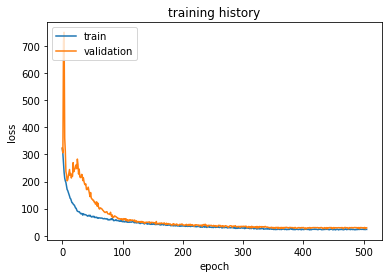

In [15]:
# train
history = model.fit(
    batch_size=16,
    validation_batch_size=4,
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');